# Distribution of Colours
This notebook plots the distribution of most excitatory and most inhibitory colours for spectrally opponent cells at different depths in our model. It corresponds to Figure 4 from the paper.

**Note**: The easiest way to use this is as a colab notebook, which allows you to dive in with no setup.

## Load Dependencies - Colab Only

In [ ]:
from os.path import exists
if not exists('opponency.zip'):
    !wget -O opponency.zip https://github.com/ecs-vlc/opponency/archive/master.zip
    !unzip -qq opponency.zip
    !mv opponency-master/* ./
    !rm -r opponency-master

## Generate Plots

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.font_manager
rc('font',**{'family':'serif','serif':['Computer Modern Roman'],'size':13})
rc('text', usetex=True)
# plt.rcParams.update({'font.size': 18})
import pandas as pd
import numpy as np
from scipy import stats

from matplotlib import cm
from matplotlib import transforms
import matplotlib as mpl
from scipy.stats import gaussian_kde

titles = {'retina_relu2': 'Retina 2', 'ventral_relu0': 'Ventral 1',
          'ventral_relu1': 'Ventral 2'}

def plot(ax, frame, layer, n_bn, d_vvs, label, title=False):
    frame = frame[frame['layer'] == layer].copy()
    
    frame['max_params'] = (frame['max_params'] * 2 * np.pi) / 360
    frame['min_params'] = (frame['min_params'] * 2 * np.pi) / 360
    
    exs = []
    ins = []
    
    main_frame = frame
    
    for rep in range(9):
        frame = main_frame[main_frame['rep'] == rep]
        frame = pd.concat([frame[frame['d_vvs'] == d] for d in d_vvs])
        frame = pd.concat([frame[frame['n_bn'] == n] for n in n_bn])
                
        exc = np.histogram(frame['max_params'], bins=45, range=(0,2 * np.pi), density=True)
        inh = np.histogram(frame['min_params'], bins=45, range=(0,2 * np.pi), density=True)

        def get_data(x):
            xs = list(x[1])

            ys = list(x[0])
            ys.append(ys[0])

#             if(m == 0):
#                 return xs, ys

#             ys = [(ys[i] / m) for i in range(len(ys))]
            return xs, ys

        exc1, exc2 = get_data(exc)
        inh1, inh2 = get_data(inh)

        exs.append(exc2)
        ins.append(inh2)
    
    # Define colormap normalization for 0 to 2*pi
    norm = mpl.colors.Normalize(0, 2*np.pi) 

    # Plot a color mesh on the polar plot
    # with the color set by the angle

    n = 2000  #the number of secants for the mesh
    t = np.linspace(0,2*np.pi,n)   #theta values
    r = np.linspace(0.85,1,2)        #radius values change 0.6 to 0 for full circle
    rg, tg = np.meshgrid(r,t)      #create a r,theta meshgrid
    c = tg                         #define color values as theta value
    im = ax.pcolormesh(t, r, c.T, norm=norm, cmap='hsv')  #plot the colormesh on axis with colormap
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.spines['polar'].set_visible(False)    #turn off the axis spine.
    
    exs = np.array(exs)
    ins = np.array(ins)
    
    exs = (exs / np.max(np.mean(exs, axis=0) + np.std(exs, axis=0))) * 0.8
    ins = (ins / np.max(np.mean(ins, axis=0) + np.std(ins, axis=0))) * 0.8
    
#     exs = exs * 0.8
#     ins = ins * 0.8
    
    ex_mean = np.mean(exs, axis=0)
    in_mean = np.mean(ins, axis=0)
    
    ax.plot(exc1, ex_mean, linestyle=':', label='Excitation')
    ax.plot(inh1, in_mean, linestyle='--', label='Inhibition')
    
    ex_std = np.std(exs, axis=0)
    in_std = np.std(ins, axis=0)
    
    ax.fill_between(
        exc1,
        ex_mean + ex_std,
        ex_mean - ex_std,
        alpha=0.1
    )
    
    ax.fill_between(
        inh1,
        in_mean + in_std,
        in_mean - in_std,
        alpha=0.1
    )
    
    if title:
        ax.set_title(titles[layer], pad=15)
    
    if layer == 'retina_relu2':
        ax.set_ylabel(label, labelpad=25, fontsize='large')
    
#     if legend and layer == 'ventral_relu0':
#         ax.legend(bbox_to_anchor=(0.5, -0.05), loc='upper center', ncol=2, frameon=False, columnspacing=1)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


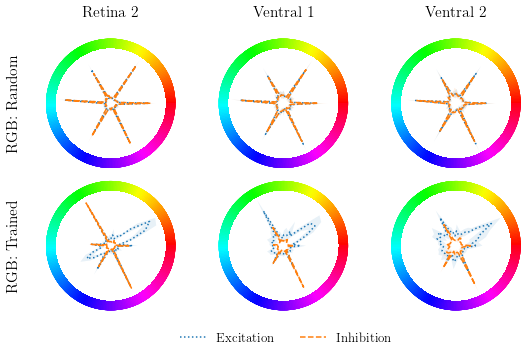

In [2]:
layers = ['retina_relu2', 'ventral_relu0', 'ventral_relu1']

params = [
    ('RGB: Random', [1, 2, 4, 8, 16, 32], [0, 1, 2, 3, 4], pd.read_pickle('statistics/devalois-random.pd')),
    ('RGB: Trained', [1, 2, 4, 8, 16, 32], [0, 1, 2, 3, 4], pd.read_pickle('statistics/devalois.pd'))
]

fig, axs = plt.subplots(len(params), 3, subplot_kw=dict(polar=True), gridspec_kw={'hspace': 0.1, 'wspace': 0.1})
fig.set_size_inches(9, 2.5 * len(params))

for i, layer in enumerate(layers):
    for j, param in enumerate(params):
        label, n_bn, d_vvs, frame = param
        try:
            ax = axs[j, i]
        except IndexError:
            ax = axs[i]
        plot(ax, frame, layer, n_bn, d_vvs, label, j==0)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.44, 0.1), loc='upper center', ncol=2, frameon=False)            

plt.savefig('figures/excitatory_colours_rgb.pdf', bbox_inches='tight')

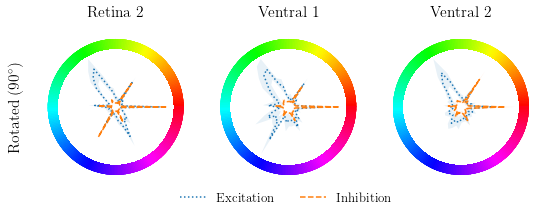

In [3]:
layers = ['retina_relu2', 'ventral_relu0', 'ventral_relu1']

params = [
    ('Rotated (90$^\circ$)', [1, 2, 4, 8, 16, 32], [0, 1, 2, 3, 4], pd.read_pickle('statistics/devalois-distort.pd'))
]

fig, axs = plt.subplots(len(params), 3, subplot_kw=dict(polar=True), gridspec_kw={'hspace': 0.1, 'wspace': 0.1})
fig.set_size_inches(9, 2.5 * len(params))

for i, layer in enumerate(layers):
    for j, param in enumerate(params):
        label, n_bn, d_vvs, frame = param
        try:
            ax = axs[j, i]
        except IndexError:
            ax = axs[i]
        plot(ax, frame, layer, n_bn, d_vvs, label, j==0)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.44, 0.15), loc='upper center', ncol=2, frameon=False)            

plt.savefig('figures/excitatory_colours_distort.pdf', bbox_inches='tight')

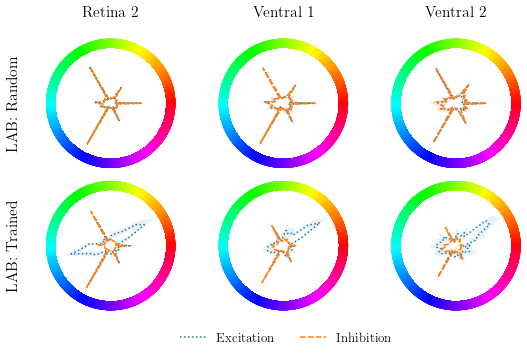

In [5]:
layers = ['retina_relu2', 'ventral_relu0', 'ventral_relu1']

params = [
    ('LAB: Random', [1, 2, 4, 8, 16, 32], [0, 1, 2, 3, 4], pd.read_pickle('statistics/devalois-random-lab.pd')),
    ('LAB: Trained', [1, 2, 4, 8, 16, 32], [0, 1, 2, 3, 4], pd.read_pickle('statistics/devalois-lab.pd')),
#     ('Rotated (90$^\circ$)', [1, 2, 4, 8, 16, 32], [0, 1, 2, 3, 4], pd.read_pickle('statistics/devalois-distort.pd'))
]

fig, axs = plt.subplots(len(params), 3, subplot_kw=dict(polar=True), gridspec_kw={'hspace': 0.1, 'wspace': 0.1})
fig.set_size_inches(9, 2.5 * len(params))

for i, layer in enumerate(layers):
    for j, param in enumerate(params):
        label, n_bn, d_vvs, frame = param
        try:
            ax = axs[j, i]
        except IndexError:
            ax = axs[i]
        plot(ax, frame, layer, n_bn, d_vvs, label, j==0)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.44, 0.1), loc='upper center', ncol=2, frameon=False)            

plt.savefig('figures/excitatory_colours_lab.pdf', bbox_inches='tight')